# MONITORING THE SAHARAN AIR LAYER USING SATELLITES

Presenter: Rebekah Esmaili, Science and Technology Corportation, [rebekah@stcnet.com](rebekah@stcnet.com)

Significant Hazards Satellite Applications Short Course 

29 September 2019, Boston, MA 

![SAL on 9/20/2019](images/SAL.jpeg)

## What is the Saharan Air Layer?

The Saharan Air Layer (SAL) is a hot and dry pocket of air that originates over the Saharan Desert and propagates over the Atlantic. The SAL extends from 850-500mb and has very steep lapse rates, thus capping the moist, tropical marine air below. This can potentially suppress tropical cyclone formation. The SAL is a potential hazard because it can transport aerosols to populated regions across the Atlantic, reducing air quality over the Caribbean and eastern United States. This can increase allergies and asthma in sensitive populations. 

The image above shows a SAL outbreak on September 15, 2018 using the VIIRS instrument from the Suomi NPP satellite. This outbreak reached the Caribbean on September 20, 2018. The SAL can be detected from space by examining visible and infrared imagery from a variety of sensors on satellite platform, such as the ABI (GOES-16), SEVIRI (Meteosat-9/-10), VIIRS (Suomi NPP, NOAA-20), and AVHRR (MetOp-A, -B, -C). The horizontal extent of the SAL can be monitored using dust RGB imagery, channel differencing (e.g., 10.33 µm - 12.30 µm), and Aerosol Optical Depth (AOD) retrievals. Additionally, microwave and infrared sounding (CrIS, ATMS, AMSU, and IASI) are particularly useful for SAL monitoring because sounder products can detect both the horizontal and vertical distribution of the dry air mass.

## What is NUCAPS?
The NOAA Unique Combined Atmospheric Processing System (NUCAPS) operationally produces atmospheric sounding products from the Suomi National-Polar-orbiting Partnership (Suomi NPP), NOAA-20, and MetOp series polar orbiting satellites. From each satellite, NUCAPS provides global, twice-daily scans and is available in near real-time. NUCAPS provides vertical profiles of temperature, humidity, and trace gases such as ozone, methane, and carbon monoxide.

NUCAPS humidity profiles is useful for studying the vertical profile of SAL and to verify model predictions for SAL propagation.


## Where can I get NUCAPS datasets?
Data can be ordered from [NOAA CLASS](https://www.bou.class.noaa.gov/saa/products/search?sub_id=0&datatype_family=JPSS_SND&submit.x=24&submit.y=7), under the JPSS Sound Products (JPSS_SND) drop down menu.

## How can I visualize NUCAPS datasets?
The daily ascending and descending overpasses can be viewed online via the [NOAA/STAR](https://www.star.nesdis.noaa.gov/jpss/EDRs/products_Soundings_N20.php). Additionally, skew-T visualizations are routinely produced by [NOAA/OSPO](https://www.ospo.noaa.gov/Products/atmosphere/soundings/nucaps/pskewt/USACON.html) for NOAA-20, Suomi NPP, and MetOp series.

Below is a short tutorial on how to display NUCAPS using Python and Jupyter Notebooks. This tutorial is intended to be a beginner-friendly exercise. So, even if
you are not a Python programmer, you may be able to port it to another
language of choice.

### Objectives
* Open and inspect a single NUCAPS file, containing one swath of data
* Create maps and vertical cross section plots
* Combine many single files onto a map

First, we will import several 'helper' libraries to process the data. the '\#' symbole indicates comments and will not run with the code.

In [1]:
import numpy as np                         # To perform array operations
import cartopy.crs as ccrs                 # To create map projections for plots
import cartopy.feature as cfeature         # To add maps to plots
from glob import glob                      # Search all files in a directory
import matplotlib.pyplot as plt            # Main plotting library
import xarray as xr                        # For working with netCDF files and large arrays

plt.rcParams['figure.figsize'] = [15, 10] # Sets all figures in document to be 15"x10"
plt.rcParams.update({'font.size': 21})     # Sets fontsize in document to 21pts

### The JPSS file naming scheme

The code below will read in a single netCDF file. The file names are very long!

__NUCAPS-EDR_v2r0_npp_s201809201634390_e201809201635090_c201809201739220.nc__

But there's a general trend in the filenames, so using the underscore (\_) as a seperator:

* NUCAPS-EDR: product
* v2r0: algorithm
* npp: satellite
* s201809201634390: start time
* e201809201635090: end time
* c201809201739220: creation time

By looking at the start and end times of the name, we see that the file contains 1 minute of NUCAPS data collected from the Suomi NPP sensors. 

### Importing a single granule of data using xarray

Using the open_dataset command in xarray, let's import the file. Note that we need the decode_times option to be false, because xarray expects them to be stored in miliseconds and the NUCAPS files stores them in nanoseconds.

In [2]:
# Read in a single NUCAPS netcdf file 
# Set decode time = false (the time doesnt follow standard formatting)
fname = 'sal/NUCAPS-EDR_v2r0_npp_s201809201638230_e201809201638530_c201809201742190.nc'
nucaps = xr.open_dataset(fname, decode_times=False)

In [3]:
# Uncomment to inspect the file contents...
nucaps

<xarray.Dataset>
Dimensions:               (Number_of_Cloud_Emis_Hing_Pts: 100, Number_of_Cloud_Layers: 8, Number_of_CrIS_FORs: 120, Number_of_Ispares: 129, Number_of_MW_Spectral_Pts: 16, Number_of_P_Levels: 100, Number_of_Rspares: 262, Number_of_Stability_Parameters: 16, Number_of_Surf_Emis_Hinge_Pts: 100)
Coordinates:
    Time                  (Number_of_CrIS_FORs) float64 ...
    Latitude              (Number_of_CrIS_FORs) float32 ...
    Longitude             (Number_of_CrIS_FORs) float32 ...
    Pressure              (Number_of_CrIS_FORs, Number_of_P_Levels) float32 ...
    Effective_Pressure    (Number_of_CrIS_FORs, Number_of_P_Levels) float32 ...
Dimensions without coordinates: Number_of_Cloud_Emis_Hing_Pts, Number_of_Cloud_Layers, Number_of_CrIS_FORs, Number_of_Ispares, Number_of_MW_Spectral_Pts, Number_of_P_Levels, Number_of_Rspares, Number_of_Stability_Parameters, Number_of_Surf_Emis_Hinge_Pts
Data variables:
    quality_information   |S1 ...
    CrIS_FORs             (Number

### Creating a simple map

If successfully imported, the command above will display the dimensions, coordinates, and available variables to plot. First, we will make a map showing where this granule is by plotting the latitude and logitude coordinates. NUCAPS data is saved as a 120 field of regards (FORs). This is stored as the "CrIS_FORs" coordinate in the NUCAPS netCDF file. Each FOR is 50km near nadir and 150km at the scan edge. 

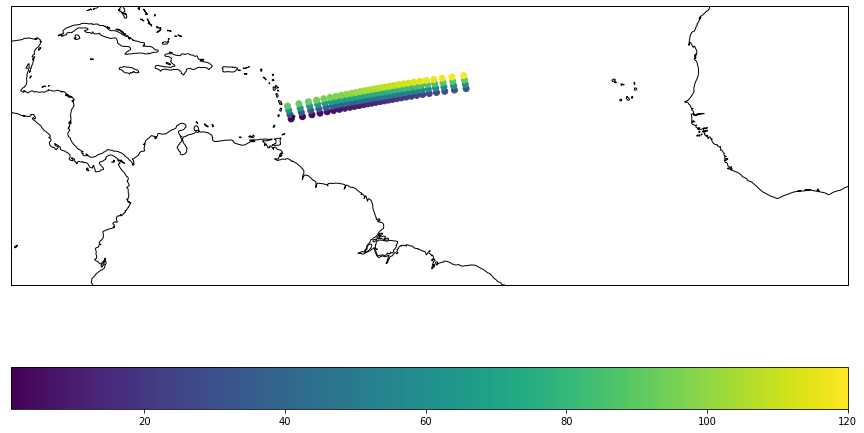

In [4]:
# Initiate the plot
fig = plt.figure(figsize=(15, 10))

# Adds a map to the plot
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m')

# Plots the latitude and longitude of the NUCAPS data
plt.scatter(nucaps['Longitude'], nucaps['Latitude'], c=nucaps['CrIS_FORs'])

plt.colorbar(orientation='horizontal')

# Expands axes
ax.set_ylim(-5, 25)
ax.set_xlim(-90, 0)

# Display plot
plt.show()

From above, the 120 FORs are numbered linearly, starting at one in the lower left of the swath, increase to the right, resetting to a new row with every 30th observation.

### Plotting a vertical profile of water vapor to examine the SAL structure

From the list of data variables, we have access to vertical profiles of temperature, H$_{2}$O, O$_{3}$, CO, etc. Since the SAL is dry, we will see a dry layer when looking at the vertical profiles for each FOR.

To make this plot, we have to make sure all the variables are the same dimensions. By printing below, we'll see that the CRIS_FORs are one-dimensional while pressure and H$_{2}$O are two-dimensional:

In [5]:
print(nucaps['Pressure'].shape, nucaps['H2O'].shape, nucaps['CrIS_FORs'].shape)

(120, 100) (120, 100) (120,)


We can use the repeat and command to repeat the 100 pressure levels 120 times, once for each FOR. Then we will reshape this 1D array into a 2D array to match the other two variables:

In [6]:
repeatFORs = np.repeat(nucaps['CrIS_FORs'].values, 100).reshape(120,100)
repeatFORs

array([[  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  2.,   2.,   2., ...,   2.,   2.,   2.],
       [  3.,   3.,   3., ...,   3.,   3.,   3.],
       ...,
       [118., 118., 118., ..., 118., 118., 118.],
       [119., 119., 119., ..., 119., 119., 119.],
       [120., 120., 120., ..., 120., 120., 120.]])

Now, we can make a contour plot, which requires three inputs: the x-axis variable (FOR), the y-axis variable (pressure), and the z variable or color coding (H2O). In the plot below, we do not include a map since it's a profile but we do invert the y axis, because pressure decreases with height and by default, matplotlib will make the plot in ascending order.

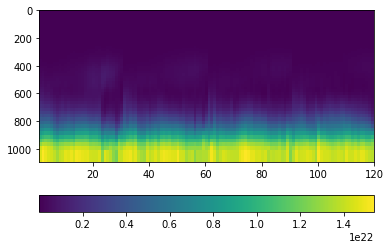

In [7]:
# Initiate the plot
fig = plt.figure()

# Plots the latitude and longitude of the NUCAPS data
plt.pcolormesh(repeatFORs, nucaps['Pressure'], nucaps['H2O'].values)

plt.colorbar(orientation='horizontal')

# Reverse the y axes
plt.gca().invert_yaxis()

# Display plot
plt.show()

You may observe the repeating pattern above. That's because the the row resets after every 30th FOR. However, we can  see that the air is quite dry above 850mb. Since the SAL is typically dry between 850-500mb, our swath may be capturing the SAL.  In the next section, we will gain greater situational awareness examining a horizontal swath of data.

### Creating a horizontal cross section map of moisture to find pockets of dry air

Let's make a map of the horizontal cross section of water vapor near 500mb. NUCAPS is gridded to an irregular set of pressure levels, so we need to find the closest one to 500mb. Below, we make a dictionary of all the pressure levels contains in the file. The first line prints all the pressure levels as integers (dtype='i4') from the first FOR (since they're repeating, we only need one), converts it to a numpy array using np.array(...). Then, the loop appends all the pressure levels and their index.

In [8]:
# Make a dictionary with pressure levels and indices ...
pressureLevs = np.array(nucaps.sel(Number_of_CrIS_FORs=0).Pressure.values, dtype='i4')

PresLevIndex = {}
for i, plev in enumerate(pressureLevs):
    PresLevIndex.update( {plev : i} )

Below prints out all available pressure levels that we can choose from; we can see that the closest to 500mb is 496mb.

In [9]:
# Print out all pressure levels in the dictionary
PresLevIndex.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 14, 16, 18, 20, 23, 26, 29, 32, 35, 39, 43, 47, 51, 56, 60, 66, 71, 77, 83, 89, 96, 103, 110, 117, 125, 133, 142, 151, 160, 170, 180, 190, 200, 212, 223, 235, 247, 259, 272, 286, 300, 314, 328, 343, 358, 374, 390, 407, 424, 441, 459, 477, 496, 515, 535, 555, 575, 596, 617, 639, 661, 683, 706, 729, 753, 777, 802, 827, 852, 878, 904, 931, 958, 986, 1013, 1042, 1070, 1100])

The procedure above is handy because we can use the index to select the pressure levels we want to take a slice from, which we'll map to a new variable griddedView.

In [10]:
griddedView = nucaps.sel(Number_of_P_Levels=PresLevIndex[496])
#griddedView

Below, we make a map showing the horizontal cross section of water vapor.

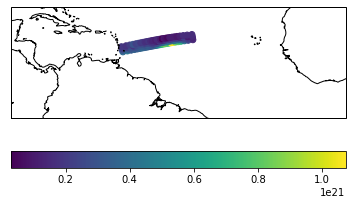

In [11]:
# Initiate the plot
fig = plt.figure()

# Adds a map to the plot
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m')

# Plots the latitude and longitude of the NUCAPS data
plt.scatter(griddedView['Longitude'], griddedView['Latitude'], c=griddedView['H2O'])

plt.colorbar(orientation='horizontal')

# Expands axes
ax.set_ylim(-5, 25)
ax.set_xlim(-90, 0)

# Display plot
plt.show()

### Importing multiple granules of data using xarray

The above map is interesting, but it only represents a small area. By importing more granules of data, we can examine a larger area. Using glob, we can search for all files in a directory. Instead of open_dataset, we can use xarrays open_mfdataset (multi file dataset) all at the same time.

In [12]:
# Import all files (may take a momenbt...)
allfiles = glob("sal/NUCAPS-EDR_v2r0_npp_s*.nc")
nucapsAll = xr.open_mfdataset(allfiles, decode_times=False)

### Filtering data by quality

We can repeat the steps we did for the single granule to make a map of water vapor at 496mb. However, let's do one last thing, which is filter by data quality. NUCAPS uses both microwave and infrared based retrievals for the best quality retrievals. However, these retrievals can fail within uniform cloud decks. We can use the where command to keep the good data (Quality_Flag == 0) and drop the rest data (Quality_Flag==1).

In [13]:
griddedViewAll = nucapsAll.sel(Number_of_P_Levels=PresLevIndex[496])

# To filter by quality flag:
griddedViewAll = griddedViewAll.where(griddedViewAll['Quality_Flag'] == 0, drop=True)

### Plotting multiple, quality filtered water vapor cross sections to see the extent of the SAL

The code below is identical to our single granule example, however, but now we have more granules to look at in our plot:

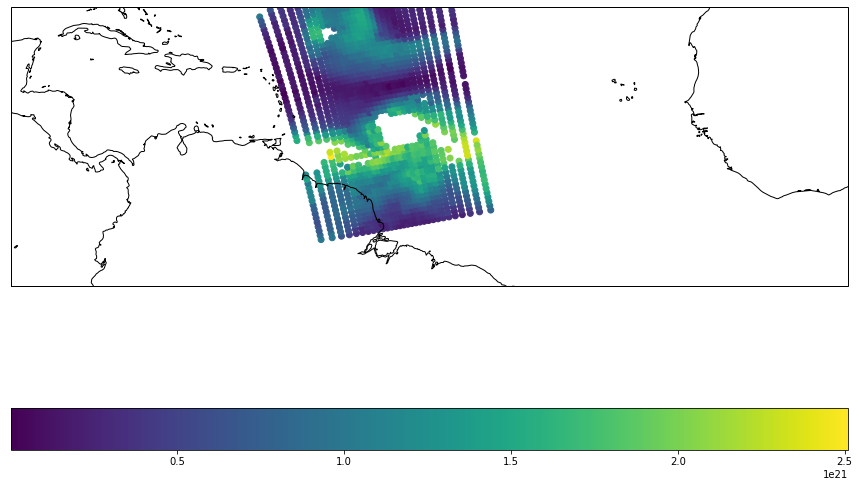

In [14]:
# Initiate the plot
fig = plt.figure(figsize=(15, 15))

# Adds a map to the plot
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m')

# Plots the latitude and longitude of the NUCAPS data
plt.scatter(griddedViewAll['Longitude'], griddedViewAll['Latitude'], \
            c=griddedViewAll['H2O'])

plt.colorbar(orientation='horizontal')

# Expands axes
ax.set_ylim(-5, 25)
ax.set_xlim(-90, 0)

# Display plot
plt.show()

Looking above, we can see a very dry layer of air. From the GOES-16 Split Window Difference (10.33 µm – 12.30 µm) , we can confirm the presense of the SAL:

![](images/20180920.15.NWAtlantic.SALgoes16split.png)


## Conclusions

* The Saharan Air Layer can be seen from space using visible and infrared imagery and products. Hyperspectral sounding data can be used to see both the vertical and horizontal extent.
* NUCAPS is useful for examining the moisture and temperature structure of SAL events.
* Both code and web-based tools can be used and data are freely available online for monitoring potential SAL cases.